# Распознавание образов

## Описание проекта

Необходимо разработать рабочий проект по распознаванию человеческих лиц с идентификацией человека (например, его имя). На вход системе будет подаваться **видеопоток** в реальном времени. На выходе – **распознанное и идентифицированное лицо.**

In [9]:
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## 1. Каскады Хаара (библиотека OpenCV)

### Два способа:
   - собственный классификатор с настроенными весами;
   - с готовыми весами под всех людей;

### Обучение классификатора (файл cascade.xml)

<img src="1.jpg">

In [18]:
import cv2
from cv2 import CascadeClassifier
import sys
import os
import face_recognition
import numpy as np

# достаем из папки изображения и заносим их в списки изображений и имен
path = 'Images' # путь к фото
images = [] # для фото
classNames = [] # для имен
distance_dict = {}

myList = os.listdir(path)
#print(myList)
for cl in myList:
    curImg = cv2.imread(f'{path}/{cl}')
    images.append(curImg)
    classNames.append(os.path.splitext(cl)[0])
print(classNames)
 
def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
    return encodeList

encodeListKnown = findEncodings(images) # находим кодировки с помощью face_encodings для каждого изображения в папке
print('Encoding Complete')


# для детектирования используем каскады Хаара
faceCascade = CascadeClassifier('haarcascade_frontalface_default.xml') # haarcascade_frontalface_default.xml
video_capture = cv2.VideoCapture(0)            # cascade.xml

while True:
    # считываем кадр за кадром
    ret, img = video_capture.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Функция faceCascade.detectMultiScale() определяет области на фотографии, где есть человеческие
    # лица. Она возвращает список с параметрами [x,y,w,h] для каждого найденного лица. Эти
    # параметры описывают прямоугольную область в том месте, где нашлось лицо.
    
    faces = faceCascade.detectMultiScale(
        img, # изображение
        scaleFactor=1.1, # параметр определяет то, на сколько будет увеличиваться скользящее окно поиска на каждой итерации. 
                        #1.1 означает на 10%, 1.05 на 5% и т.д. Чем больше это значение, тем быстрее работает алгоритм.
        minNeighbors=5, # Параметр, указывающий, сколько соседей должен иметь каждый прямоугольник-кандидат, чтобы сохранить его.
                        # Чем больше это значение, тем более параноидальным будет поиск и тем чаще он будет пропускать
                        # реальные лица, считая, что это ложное срабатывание.
        minSize=(30, 30), # минимальный размер лица на фото
        flags=cv2.CASCADE_SCALE_IMAGE)    
    
    encodesCurFrame = face_recognition.face_encodings(img) # находим кодировку лица в кадре
    for encodeFace,faceLoc in zip(encodesCurFrame,faces): # для найденных кадировок и местоположений
        matches = face_recognition.compare_faces(encodeListKnown,encodeFace) # сравниваем лица (true or false)
        faceDis = face_recognition.face_distance(encodeListKnown,encodeFace) # находим Евклидово расстояние между лицами
        
        matchIndex = np.argmin(faceDis) # находим индексс минимального расстояния
        # print("MatchIndex:", matchIndex)
        
        if matches[matchIndex]: # если в списке сравненных лиц по полученному индексу True, то рисуем прямоугольник и имя
            name = classNames[matchIndex].upper()
            if name not in distance_dict.keys():
                distance_dict[name] = []
            else: #if name in distance_dict.keys():
                distance_dict[name].append(faceDis[matchIndex])
            #print(name)
            x1, y1, x2, y2 = faceLoc
            cv2.rectangle(img,(x1,y1),(x1+x2,y1+y2),(0,255,0),2)
            cv2.rectangle(img,(x1,y1+y2-35),(x1+x2,y1+y2),(0,255,0),cv2.FILLED)
            cv2.putText(img,name + f'__{faceDis[matchIndex]:.2f}',(x1+6,y1+y2-6),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
        else:
            cv2.rectangle(img, (x1,y1),(x1+x2,y1+y2), (0, 0, 255), 2)
            cv2.rectangle(img,(x1,y1+y2-35),(x1+x2,y1+y2),(0,0,255),cv2.FILLED)
            cv2.putText(img, 'UNKNOWN', (x1+6,y1+y2-6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
        
    # отображаем результат на фрейме
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imshow('Haar Cascades', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

['Dima', 'Guzel', 'Olya', 'Sasha', 'Yana']
Encoding Complete


In [19]:
# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

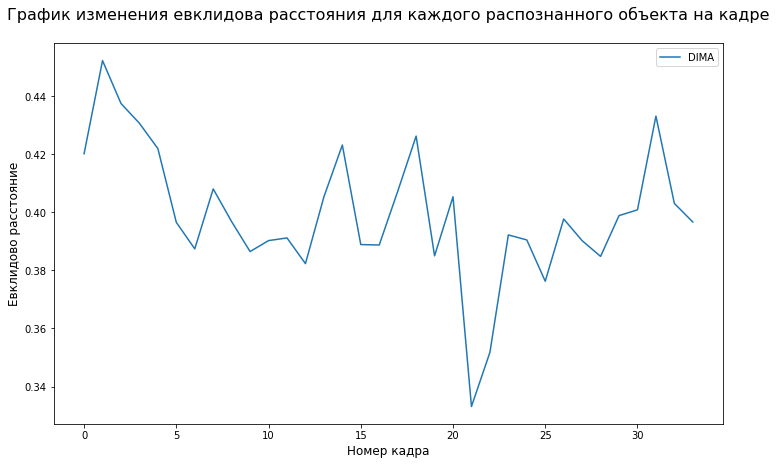

In [12]:
plt.figure(figsize=(12,7))
for name in distance_dict.keys():
    plt.plot(range(len(distance_dict[name])), distance_dict[name], label=name)
plt.legend()
plt.title('График изменения евклидова расстояния для каждого распознанного объекта на кадре\n', fontsize=16)
plt.xlabel('Номер кадра', fontsize=12)
plt.ylabel('Евклидово расстояние', fontsize=12)
plt.show()

## 2. HOG и CNN (библиотека Face Recognition)

In [7]:
#!pip install face_recognition

In [15]:
import cv2
import numpy as np
import face_recognition
import os
from datetime import datetime

# достаем из папки изображения и заносим их в списки изображений и имен
path = 'Images' # путь к фото
images = [] # для фото
classNames = [] # для имен
distance_dict = {}

myList = os.listdir(path)
#print(myList)
for cl in myList:
    curImg = cv2.imread(f'{path}/{cl}')
    images.append(curImg)
    classNames.append(os.path.splitext(cl)[0])
print(classNames)
 
def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
    return encodeList

encodeListKnown = findEncodings(images) # находим кодировки с помощью face_encodings для каждого изображения в папке
print('Encoding Complete')
 
video_capture = cv2.VideoCapture(0)

while True:
    ret, img = video_capture.read() # считываем кадр
    #img = captureScreen() 
    imgS = cv2.resize(img,(0,0),None,0.25,0.25)
    imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)
 
    facesCurFrame = face_recognition.face_locations(imgS) # находим местоположение лица в кадре
    encodesCurFrame = face_recognition.face_encodings(imgS,facesCurFrame) # находим кодировку лица в кадре
    #print(encodesCurFrame)
    #print(facesCurFrame)
    for encodeFace,faceLoc in zip(encodesCurFrame,facesCurFrame): # для найденных кадировок и местоположений
        matches = face_recognition.compare_faces(encodeListKnown,encodeFace) # сравниваем лица (true or false)
        faceDis = face_recognition.face_distance(encodeListKnown,encodeFace) # находим Евклидово расстояние между лицами
        # print("FaceDis:", faceDis)
        matchIndex = np.argmin(faceDis) # находим индексс минимального расстояния
        # print("MatchIndex:", matchIndex)
        
        if matches[matchIndex]: # если в списке сравненных лиц по полученному индексу True, то рисуем прямоугольник и имя
            name = classNames[matchIndex].upper()
            if name not in distance_dict.keys():
                distance_dict[name] = []
            else: #if name in distance_dict.keys():
                distance_dict[name].append(faceDis[matchIndex])
            #print(name)
            y1,x2,y2,x1 = faceLoc
            y1, x2, y2, x1 = y1*4,x2*4,y2*4,x1*4
            cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.rectangle(img,(x1,y2-35),(x2,y2),(0,255,0),cv2.FILLED)
            cv2.putText(img,name + f'__{faceDis[matchIndex]:.2f}',(x1+6,y2-6),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
        else:
            cv2.rectangle(img, (x1,y1), (x2,y2), (0, 0, 255), 2)
            cv2.rectangle(img,(x1,y2-35),(x2,y2),(0,0,255),cv2.FILLED)
            cv2.putText(img, 'UNKNOWN', (x1+6,y2-6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
     
    cv2.imshow('HOG',img)
    # 'q' для выхода
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# закрываем вебкамеру
video_capture.release()
cv2.destroyAllWindows()

['Dima', 'Olya', 'Sasha', 'Yana']
Encoding Complete


In [10]:
# закрываем вебкамеру
#video_capture.release()
#cv2.destroyAllWindows()

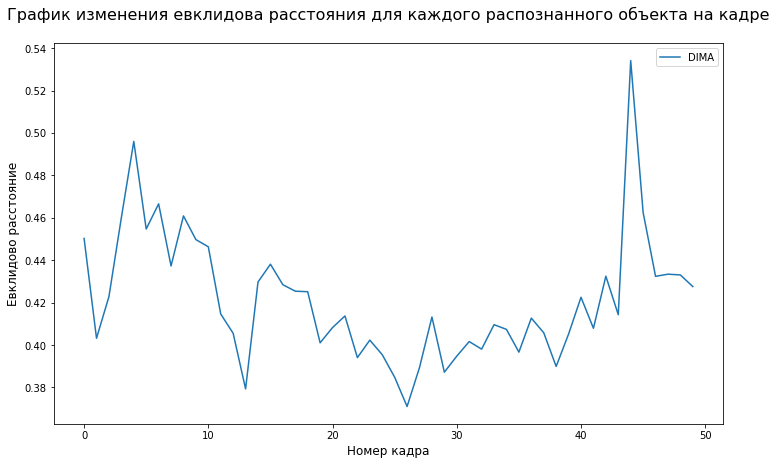

In [14]:
plt.figure(figsize=(12,7))
for name in distance_dict.keys():
    plt.plot(range(len(distance_dict[name])), distance_dict[name], label=name)
plt.legend()
plt.title('График изменения евклидова расстояния для каждого распознанного объекта на кадре\n', fontsize=16)
plt.xlabel('Номер кадра', fontsize=12)
plt.ylabel('Евклидово расстояние', fontsize=12)
plt.show()

## MTCNN

In [20]:
import tensorflow

In [21]:
#!pip install keras==2.3.1

In [22]:
import keras

In [23]:
print(tensorflow.__version__)
print(keras.__version__)

2.0.0
2.3.1


In [24]:
import os
import pickle
import numpy as np
import cv2
import mtcnn
from keras.models import load_model
import sys
sys.path.append(r"C:\Users\Dmitry\Desktop\распознавание образов\app\utils.py")
from utils import *

def findEncodings(path, encodings_path, required_size = (160, 160)): # path - путь, где лежат фото 
                                                                     # encodings_path - путь, где сохраняем файл с кодировками
    # извлечем фотографии для дальнейшей обработки
    person_names = []
    myList = os.listdir(path)
    print(myList)

    images = []

    for cl in myList:
        curImg = cv2.imread(f'{path}/{cl}')
        images.append(curImg)
        person_names.append(os.path.splitext(cl)[0])
                            
    face_detector = mtcnn.MTCNN() # модель MTCNN
    face_encoder = load_model(encoder_model) # загружаем модель
    encoding_dict = dict() # словарь кодировок
    for person_name in person_names:
        encodes = []
        for img in images:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = face_detector.detect_faces(img_rgb) # детекируем лицо
            #print(results)
            if results: # если нашли лицо
                res = max(results, key=lambda b: b['box'][2] * b['box'][3])
                face, _, _ = get_face(img_rgb, res['box'])
                #print(face)
                face = normalize(face) # нормализуем изображение (с помощью среднего и станд.откл.)
                face = cv2.resize(face, required_size) #приводим изображение к нужному размеру
                encode = face_encoder.predict(np.expand_dims(face, axis=0))[0] # находим кодировку
                encodes.append(encode)
        if encodes:
            encode = np.sum(encodes, axis=0)
            encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
            encoding_dict[person_name] = encode
    with open(encodings_path, 'bw') as file:
        pickle.dump(encoding_dict, file)

In [25]:
from scipy.spatial.distance import cosine, euclidean
# функция распознающая фото в кадре и вычисляющая кодировку
def recognize(img, # кадр
              detector, # детектор
              encoder, # энкодер
              encoding_dict, # словарь с вектором кодировок для каждого фото
              distance_dict, # словарь для графика
              recognition_t=0.5, # порог распознавания
              required_size=(160, 160), ): # рекомендуемый размер фото
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 
    results = detector.detect_faces(img_rgb) # 
    
    #distance_dict = {}
    
    for res in results:
        #print(results)
        face, pt_1, pt_2 = get_face(img_rgb, res['box']) # находим лицо             
        encode = get_encode(encoder, face, required_size) # находим кодировку
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0] # нормализуем
        name = 'UNKNOWN'
        #print('First step')
        distance = float("inf")
        for db_name, db_encode in encoding_dict.items(): 
            dist = cosine(db_encode, encode) # находим косинусное расстояние между лицом на кадре и лицами из папки
            #dist = euclidean(db_encode, encode)
            #if dist < distance:
            if dist < recognition_t and dist < distance: # находим наименьшее расстояние между векторами
                name = db_name
                distance = dist
        #print('Second step')
        if name == 'UNKNOWN':
            continue
        elif name not in distance_dict.keys():
            distance_dict[name] = []
        else: #if name in distance_dict.keys():
            distance_dict[name].append(distance)
        
        if name == 'UNKNOWN':
            cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
            cv2.rectangle(img,(pt_1[0],pt_2[1]-35),pt_2,(0,0,255),cv2.FILLED)
            cv2.putText(img, name, (pt_1[0]+6, pt_2[1] - 6), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (255,255,255), 2)
        else:            
            cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
            cv2.rectangle(img,(pt_1[0],pt_2[1]-35),pt_2,(0,255,0),cv2.FILLED)
            cv2.putText(img, name + f'__{distance:.2f}', (pt_1[0]+6, pt_2[1] - 6), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (255,255,255), 2)
            for point in res['keypoints'].values():
                cv2.circle(img, point, 5, (0, 255, 0), thickness=-1)
            #print('Third step')
    return img, distance_dict

In [27]:
encoder_model = 'facenet_keras.h5' # модель FaceNet в качестве кодировщика
path = 'Images' # директория с фотографиями
encodings_path = 'encodings.pkl' # файл с кодировками фотографий

#findEncodings(path, encodings_path)

face_detector = mtcnn.MTCNN()
face_encoder = load_model(encoder_model)
encoding_dict = load_pickle(encodings_path)
distance_dict = {}

vc = cv2.VideoCapture(0)
while True:
    ret, img = vc.read()
    if not ret:
        print("no frame:(")
        break
    img, distance_dict = recognize(img, face_detector, face_encoder, encoding_dict, distance_dict)
    cv2.imshow('MTCNN', img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# When everything is done, release the capture
vc.release()
cv2.destroyAllWindows()

In [40]:
#print(encoding_dict)# When everything is done, release the capture
vc.release()
cv2.destroyAllWindows()

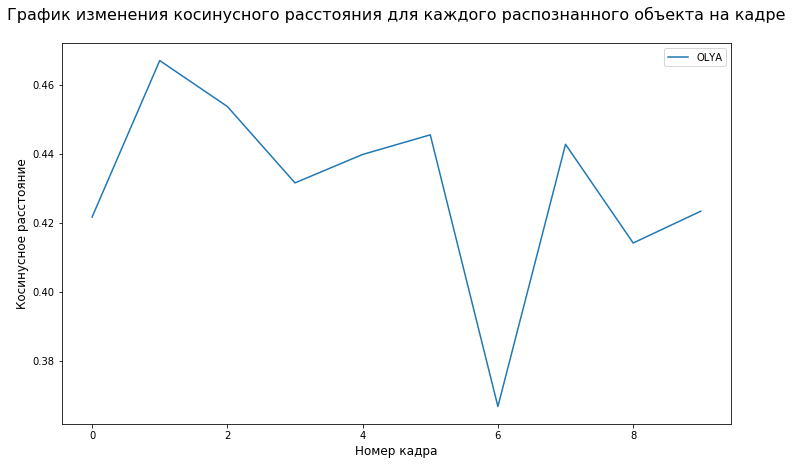

In [44]:
plt.figure(figsize=(12,7))
for name in distance_dict.keys():
    plt.plot(range(len(distance_dict[name])), distance_dict[name], label=name)
plt.legend()
plt.title('График изменения косинусного расстояния для каждого распознанного объекта на кадре\n', fontsize=16)
plt.xlabel('Номер кадра', fontsize=12)
plt.ylabel('Косинусное расстояние', fontsize=12)
plt.show()